#Test FIRDeconvolution

This notebook demonstrates the functionality of FIRDeconvolution. 

First, a signal composed of a mixture of different signals, created using a standard BOLD response HRF and a different IRF shape and gaussian noise is added. Event-related responses are then fit from this signal, demonstrating how one would use FIRDeconvolution for data analysis on recorded signals. 

We propose that first attempt at tinkering with this code would be to change the parameters in the second code cell, which specify the parameters of the simulated signal and the deconvolution. One can then run the whole notebook anew, with or without re-creating the signals. 


###Imports

In [1]:
from __future__ import division
import numpy as np
import scipy as sp

import matplotlib

import matplotlib.pyplot as pl
%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

from fir import FIRDeconvolution

###Parameters specifying simulated data and analysis

In [2]:
# signal parameters
signal_sample_frequency = 1.5
event_1_gain, event_2_gain = 2.3, 0.85
noise_gain = 0.75

# deconvolution parameters
deconv_sample_frequency = 8.0
deconvolution_interval = [-5, 25]

# how many time points to plot in figures
plot_time = 800

# create some exponentially distributed random ISI events (Dale, 1999) of which we will create and deconvolve responses. 
period_durs = np.random.gamma(4.0,1.5,size = 600)
events = period_durs.cumsum()
events_1, events_2 = events[0::2], events[1::2]

durations_1, durations_2 = np.random.gamma(2.9,0.75,size = events_1.shape[0]), np.random.gamma(2.9,0.75,size = events_2.shape[0])

# these events are scaled with their own underlying covariate. 
# for instance, you could have a model-based variable that scales the signal on a per-trial basis. 
events_gains_1 = np.random.randn(len(events_1))*0.4
events_gains_2 = np.random.randn(len(events_2))*2.4


###create an IRF which we'd like to deconvolve

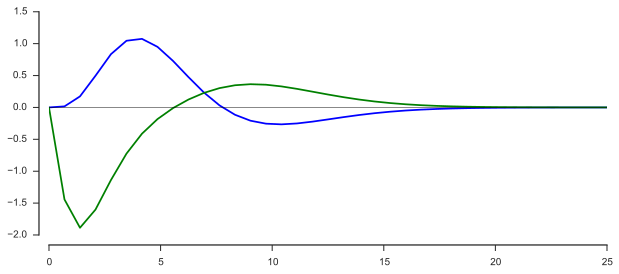

In [3]:
# We create an IRF, using a standard BOLD response and a changed version.

def double_gamma_with_d(x, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35,d1=5.4,d2=10.8):
    return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

hrf_1 = double_gamma_with_d(np.linspace(0,25,25*signal_sample_frequency), a1 = 4.5, a2 = 10, d1 = 5.0, d2 = 10.0)
hrf_2 = -double_gamma_with_d(np.linspace(0,25,25*signal_sample_frequency), a1 = 1.5, a2 = 10, d1 = 3.0, d2 = 10.0)
# hrf = hrf/np.abs(hrf).sum()

f = pl.figure(figsize = (10,4))
pl.plot(np.linspace(0,25,25*signal_sample_frequency), hrf_1, 'b')
pl.plot(np.linspace(0,25,25*signal_sample_frequency), hrf_2, 'g')
pl.axhline(0, lw=0.5, color = 'k')
sn.despine(offset=10)

#Run two simulations

1. deconvolve two types of events, each with different gains
2. deconvolve two types of events, of which the per-event gain is defined by a baseline, as in 1, and a covariate.

##Run first simulation

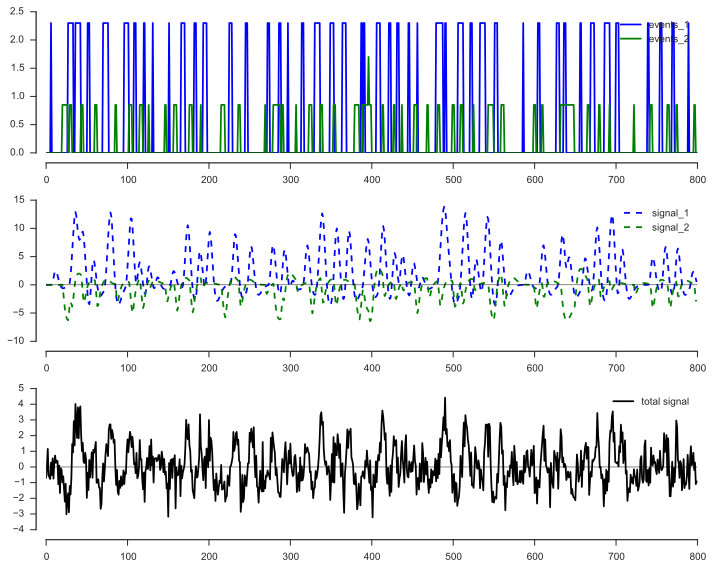

In [4]:
# Using this IRF we're going to create two signals
# signal gains are determined by random covariate and a standard gain
# we mix them all together with some noise, injected on the signal, not the events.

times = np.arange(0,events.max()+45.0,1.0/signal_sample_frequency)

event_1_in_times = np.array([((times>te) * (times<te+d)) * event_1_gain for te, d in zip(events_1, durations_1)]).sum(axis = 0)
event_2_in_times = np.array([((times>te) * (times<te+d)) * event_2_gain for te, d in zip(events_2, durations_2)]).sum(axis = 0)

signal_1 = sp.signal.fftconvolve(event_1_in_times, hrf_1, 'full')[:times.shape[0]]
signal_2 = sp.signal.fftconvolve(event_2_in_times, hrf_2, 'full')[:times.shape[0]]

# combine the two signals with one another, z-score and add noise
input_data = signal_1 + signal_2
input_data = (input_data - np.mean(input_data)) / input_data.std()
input_data += np.random.randn(input_data.shape[0]) * noise_gain



f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
pl.plot(np.arange(plot_time), event_1_in_times[:plot_time], 'b-')
pl.plot(np.arange(plot_time), event_2_in_times[:plot_time], 'g-')
pl.legend(['events_1', 'events_2',])
sn.despine(offset=10)

pl.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(312)

pl.plot(np.arange(plot_time), signal_1[:plot_time], 'b--')
pl.plot(np.arange(plot_time), signal_2[:plot_time], 'g--')
pl.legend(['signal_1', 'signal_2'])
sn.despine(offset=10)

pl.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(313)

pl.plot(np.arange(plot_time), input_data[:plot_time], 'k-')
pl.legend(['total signal'])
pl.axhline(0, lw=0.5, color = 'k')

sn.despine(offset=10)
pl.tight_layout()

##Run first analysis

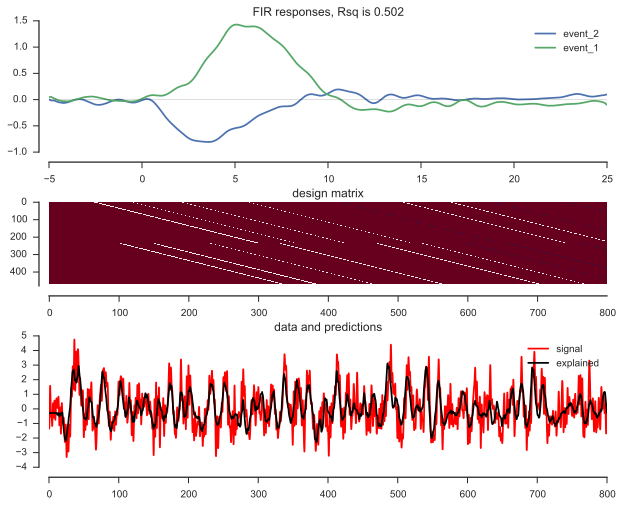

In [5]:
# When taking into account the random durations that were used to create the signal:
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            durations = {'event_1': durations_1, 'event_2': durations_2},
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval
            )

# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression, in this case with the statsmodels backend
fd.regress(method = 'lstsq')

# and partition the resulting betas according to the different event types
fd.betas_for_events()

fd.calculate_rsq()

# and we see what we've done

f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    pl.plot(fd.deconvolution_interval_timepoints, dec)
# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
pl.legend(fd.covariates.keys())
sn.despine(offset=10)

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
pl.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
pl.legend(['signal','explained'])
sn.despine(offset=10)

# with a very collinear design matrix we could use
# fd.ridge_regress(cv = 20, alphas = np.logspace(-7, 0, 20))

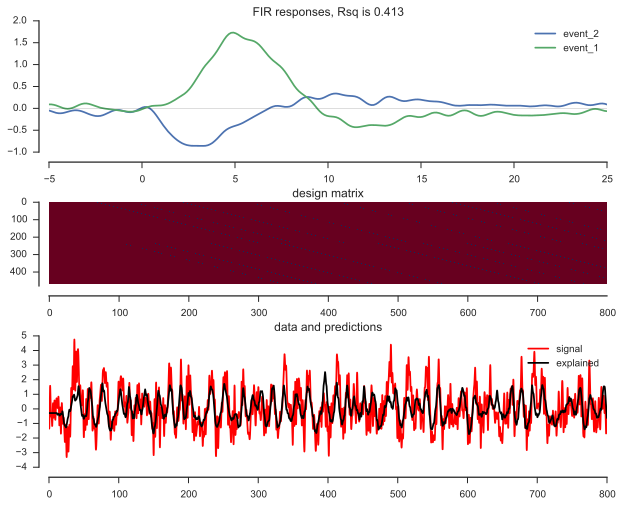

In [6]:
# Up until now, we just created data. 
# Now, we'll use the actual deconvolution package.

# first, we initialize the object
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval
            )

# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression, in this case with the statsmodels backend
fd.regress(method = 'lstsq')

# and partition the resulting betas according to the different event types
fd.betas_for_events()

fd.calculate_rsq()

# and we see what we've done

f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    pl.plot(fd.deconvolution_interval_timepoints, dec)
# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
pl.legend(fd.covariates.keys())
sn.despine(offset=10)

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
pl.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
pl.legend(['signal','explained'])
sn.despine(offset=10)

(1, 4266)
(4266,)
(480, 29637)
4266
(480, 4266)


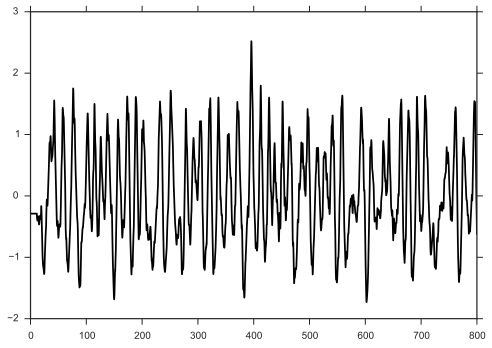

In [7]:
print fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).shape
print np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)).shape

print fd.design_matrix.shape
print int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)

print fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].shape

pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')



##Run second simulation

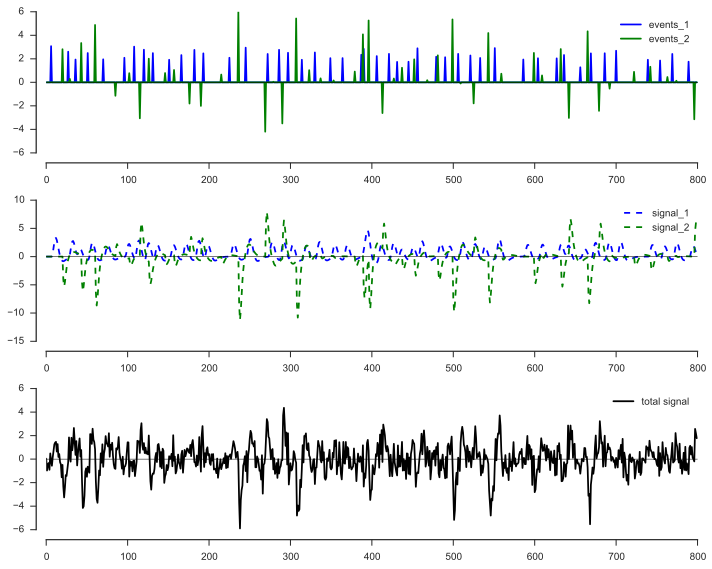

In [8]:
# Using this IRF we're going to create two signals
# signal gains are determined by random covariate per event and a standard gain
# we mix them all together with some noise, injected on the signal, not the events.

times = np.arange(0,events.max()+45.0,1.0/signal_sample_frequency)

event_1_in_times = np.array([((times>te) * (times<te+(1.0/signal_sample_frequency))) * (eg + event_1_gain) for te, eg in zip(events_1, events_gains_1)]).sum(axis = 0)
event_2_in_times = np.array([((times>te) * (times<te+(1.0/signal_sample_frequency))) * (eg + event_2_gain) for te, eg in zip(events_2, events_gains_2)]).sum(axis = 0)

signal_1 = sp.signal.fftconvolve(event_1_in_times, hrf_1, 'full')[:times.shape[0]]
signal_2 = sp.signal.fftconvolve(event_2_in_times, hrf_2, 'full')[:times.shape[0]]

# combine the two signals with one another, z-score and add noise
input_data = signal_1 + signal_2
input_data = (input_data - np.mean(input_data)) / input_data.std()
input_data += np.random.randn(input_data.shape[0]) * noise_gain

f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
pl.plot(np.arange(plot_time), event_1_in_times[:plot_time], 'b-')
pl.plot(np.arange(plot_time), event_2_in_times[:plot_time], 'g-')
pl.legend(['events_1', 'events_2',])
sn.despine(offset=10)

pl.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(312)

pl.plot(np.arange(plot_time), signal_1[:plot_time], 'b--')
pl.plot(np.arange(plot_time), signal_2[:plot_time], 'g--')
pl.legend(['signal_1', 'signal_2'])
sn.despine(offset=10)

pl.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(313)

pl.plot(np.arange(plot_time), input_data[:plot_time], 'k-')
pl.legend(['total signal'])
pl.axhline(0, lw=0.5, color = 'k')

sn.despine(offset=10)
pl.tight_layout()

##Run second analysis

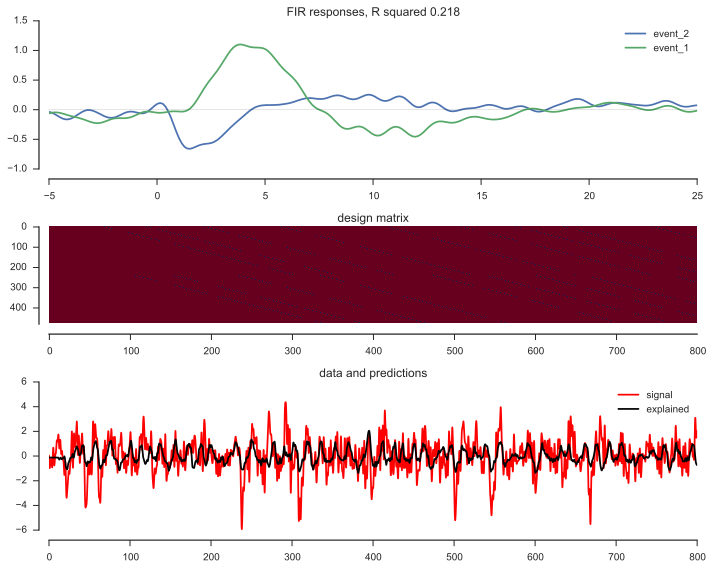

In [9]:
# we initialize the object, still without covariates - although they're in the data
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval,
            )

# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression
fd.regress(method = 'lstsq')

# and partition the resulting betas according to the different event types
fd.betas_for_events()

fd.calculate_rsq()

# and we see what we've done

f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
s.set_title('FIR responses, R squared %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    pl.plot(fd.deconvolution_interval_timepoints, dec)
pl.legend(fd.covariates.keys())
sn.despine(offset=10)

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
pl.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, 
          cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
pl.legend(['signal','explained'])
sn.despine(offset=10)
pl.tight_layout()

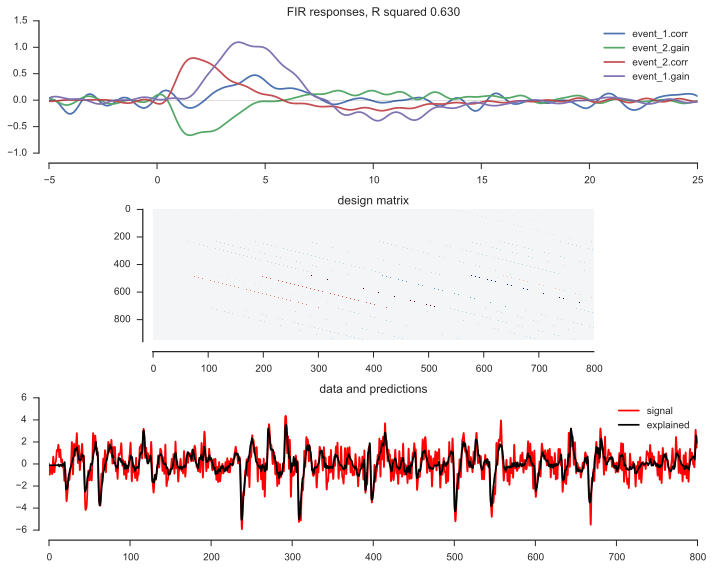

In [10]:
# But we haven't yet looked at the correlations
# the names of these are separated by a '.' to designate the events they belong to

covariates = {
    'event_1.gain': np.ones(len(events_1)), # a standard multiplication of the events for fitting the 'gain'
    'event_2.gain': np.ones(len(events_2)), # a standard multiplication of the events for fitting the 'gain'
    'event_1.corr': events_gains_1, 
    'event_2.corr': -events_gains_2, # note the multiplication with -1, for negative correlation
             }

# we initialize the object, now with the covariates
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval,
            covariates = covariates
            )

# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression
fd.regress(method = 'lstsq')

# and partition the resulting betas according to the different event types
fd.betas_for_events()

fd.calculate_rsq()

# and we see what we've done

f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
s.set_title('FIR responses, R squared %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    pl.plot(fd.deconvolution_interval_timepoints, dec)
pl.legend(fd.covariates.keys())
sn.despine(offset=10)

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
pl.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, 
          cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
pl.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
pl.legend(['signal','explained'])
sn.despine(offset=10)
pl.tight_layout()

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


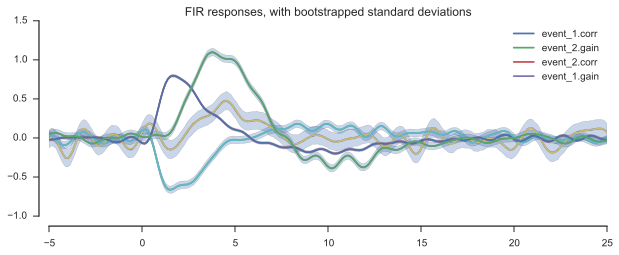

In [11]:
fd.bootstrap_on_residuals(nr_repetitions=1000)

f = pl.figure(figsize = (10,3.5))
s = f.add_subplot(111)
s.set_title('FIR responses, with bootstrapped standard deviations')
for dec in fd.betas_per_event_type.squeeze():
    pl.plot(fd.deconvolution_interval_timepoints, dec)
pl.legend(fd.covariates.keys())

for i in range(fd.bootstrap_betas_per_event_type.shape[0]):
    mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
    sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)
   
    pl.plot(fd.deconvolution_interval_timepoints, mb)
    pl.fill_between(fd.deconvolution_interval_timepoints, 
                    mb - sb, 
                    mb + sb,
                    alpha = 0.3)
# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....

sn.despine(offset=10)